# 12. Utility-Scale Experiment I 

Tamiya Onodera (July 5, 2024)<br>
© IBM Corp. 2024

*Approximate QPU time to run this experiment is 45 seconds.*

## The Utility Paper

In this lesson, we run a utility-scale circuit which appears in what we informally call ["the utility paper"](https://www.nature.com/articles/s41586-023-06096-3) published in Nature Vol 618, 15 June 2023. The paper deals with the time evolution of the 2D transverse-field Ising model. In particular, they consider time dynamics of the Hamiltonian,
$$
H = H_{ZZ} + H_X = - J \sum_{(i,j)} Z_i Z_j + h \sum_{i} X_i
$$
in which $J > 0$ is the coupling of nearest-neighbor spins with $i < j$ and $h$ is the global transverse field. 


They simulate spin dynamics from an initial state by means of first-order Trotter decomposition of the time-evolution operator,

$$
\begin{aligned}
 \exp(-i H_{ZZ} \delta t) &= \prod_{(i,j)} \exp (i J \delta t Z_i Z_j)  = \prod_{(i,j)} \mathrm{R}_{Z_i Z_j} ( - 2 J \delta t) \\
 \exp(-i H_X \delta t) &= \prod_{i} \exp (-i h \delta t X_i )  = \prod_{i} \mathrm{R}_{X_i} ( 2 h \delta t)
\end{aligned}
$$
in which the evolution time $T$ is discretized into $T / \delta t$ Trotter steps and $\mathrm{R}_{Z_i Z_j}(\theta_J)$ and $\mathrm{R}_{X_i}(\theta_h)$
are $ZZ$ and $X$ rotation gates, respectively.

They ran experiments on an IBM Quantum Eagle processor, which is a 127-qubit device with heavy-hex connectivity, applying $X$ interactions to all the qubits and $ZZ$ interactions for all the edges of the coupling map.  Please note that all the $ZZ$ interactions cannot be applied simultaneously due to "data dependance".  Hence, they **color the coupling map** to group them into layers. Those in a layer are assigned the same color, and can be applied in parallel.

In addition, for experimental simplicity, they focused on the case $\theta_J=-\pi /2$. 

The novel contribution of the paper is that they built quantum circuits at a scale beyond statevector simulation, ran them on noisy quantum computers, and succeeded in extracting reliable results. That is, they demonstrated the utility of noisy quantum computers. In doing so, they applied zero-noise extrapolation (ZNE) with probabilistic error amplification (PEA) to mitigate errors from noisy devices. 

From then on, we called such experiments and circuits "utility-scale".

## Your goal

Your goal in this lesson is to build a utility-scale circuit and run it on an Eagle processor.  It is beyond the scope of this notebook to extract reliable results, partly because PEA is an experimental feature of Qiskit at this time of writing and partly because applying ZNE with PEA will take a fair amount of time.

Concretely, you are asked to build and run the circuit corresponding to Figure 4b of the paper, and plot the "unmitigated" points of your own.  As you see, it is a 127-qubit $\times$ 60-layer (20 Trotter steps) circuit with the $\langle Z_{62} \rangle$ as an observable.

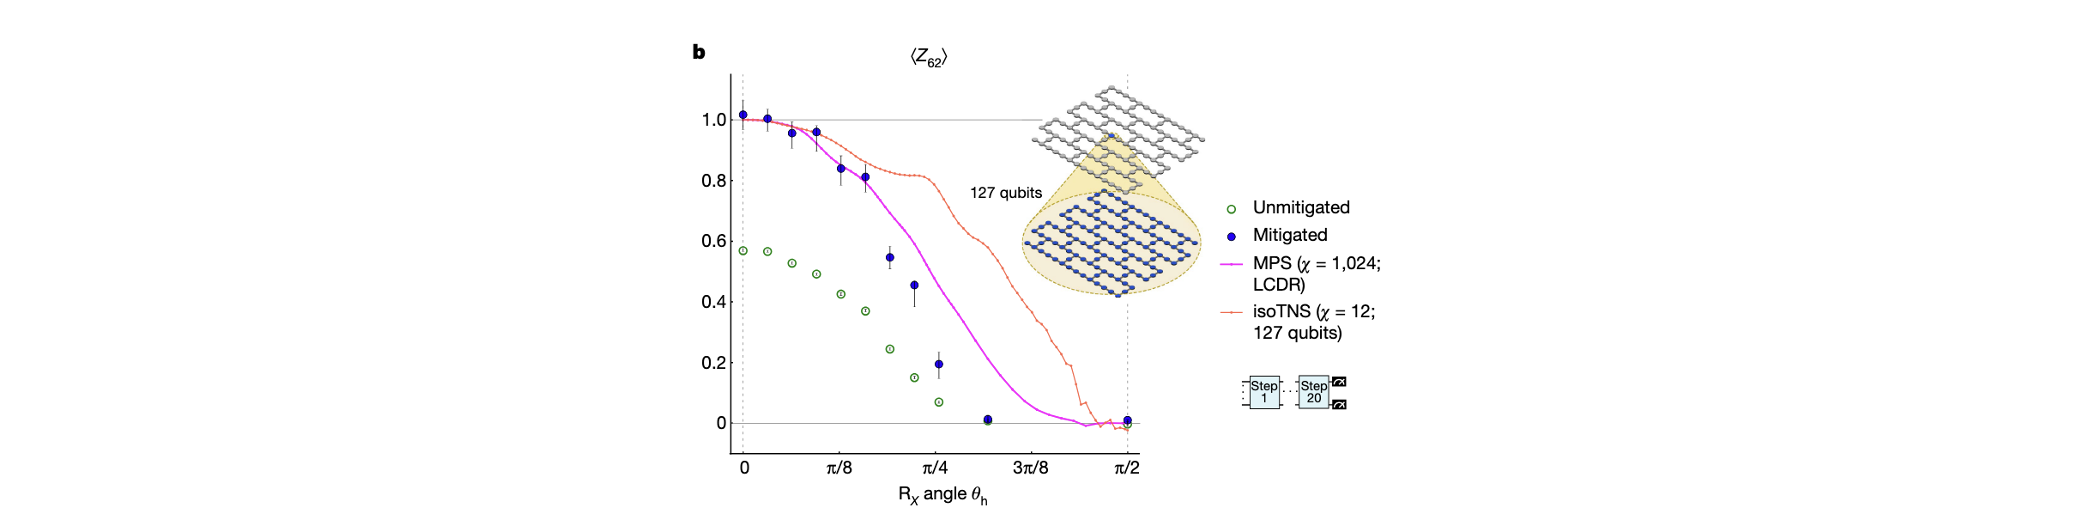

Sound like a big deal?  &nbsp; Don't worry. The last three lessons of this course provide stepping stones. To begin, we will demonstrate a smaller-scale experiment which is to build and run on a fake device a 27-qubilt $\times$ 6-layer (2 Trotter steps) circuit with the $\langle Z_{13} \rangle$ as an observable.

That's all for the introduction. Let us go on a utility-scale adventure!

In [28]:
import qiskit

qiskit.__version__

'1.3.0'

In [29]:
#!pip install qiskit_ibm_runtime
#!pip install qiskit_aer

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import YGate
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, fake_provider, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator

In [31]:
service = QiskitRuntimeService()

## Construct RZZ(-$\pi$ / 2)

First, observe that the RZZ gate in general requires two $CX$ gates.

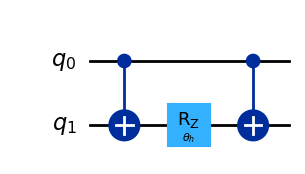

In [32]:
from qiskit.circuit.library import RZZGate
θ_h = Parameter("$\\theta_h$")
qc1= QuantumCircuit(2)
qc1.append(RZZGate(θ_h),[0, 1])
qc1.decompose(reps=1).draw("mpl")

As mentioned above, we focus on the RZZ gate with a specific angle, -$\pi$ / 2, for this experiment.  As shown in the paper, it can be realized with just one $CX$ gate.

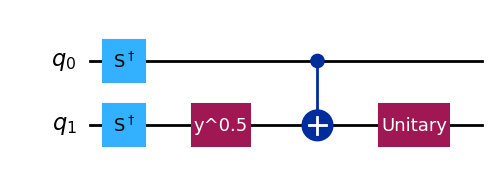

In [33]:
qc2 = QuantumCircuit(2)

qc2.sdg([0, 1])
qc2.append(YGate().power(1/2), [1])
qc2.cx(0, 1)
qc2.append(YGate().power(1/2).adjoint(), [1])

qc2.draw("mpl")

We define a gate in terms of this circuit for future reference.

In [34]:
rzz = qc2.to_gate(label="RZZ")

Let us make a random use of the newly-defined `rzz`.

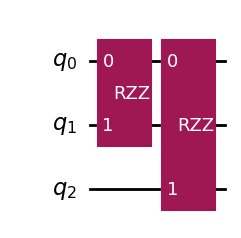

In [35]:
qc3 = QuantumCircuit(3)
qc3.append(rzz, [0,1])
qc3.append(rzz, [0,2])
display(qc3.draw("mpl"))
#display(qc.decompose(reps=1).draw("mpl"))

 Before using this further, let's verify the logical equivalence of `qc1` (the RZZ gate) for -pi/2 and our newly-defined `rzz` or `qc2` gate:

In [36]:
from qiskit.quantum_info import Operator

op1 = Operator(qc1.assign_parameters([-np.pi/2]))
op2 = Operator(qc2)

op1.equiv(op2)

True

## Color the coupling map

Let us study how we color the coupling map of a backend.  This is needed to group $ZZ$ interactions into layers. 

To begin with, let us visualize the coupling map of a backend.  Note the coupling maps are heavy-hexagonal for all the current IBM Quantum devices.

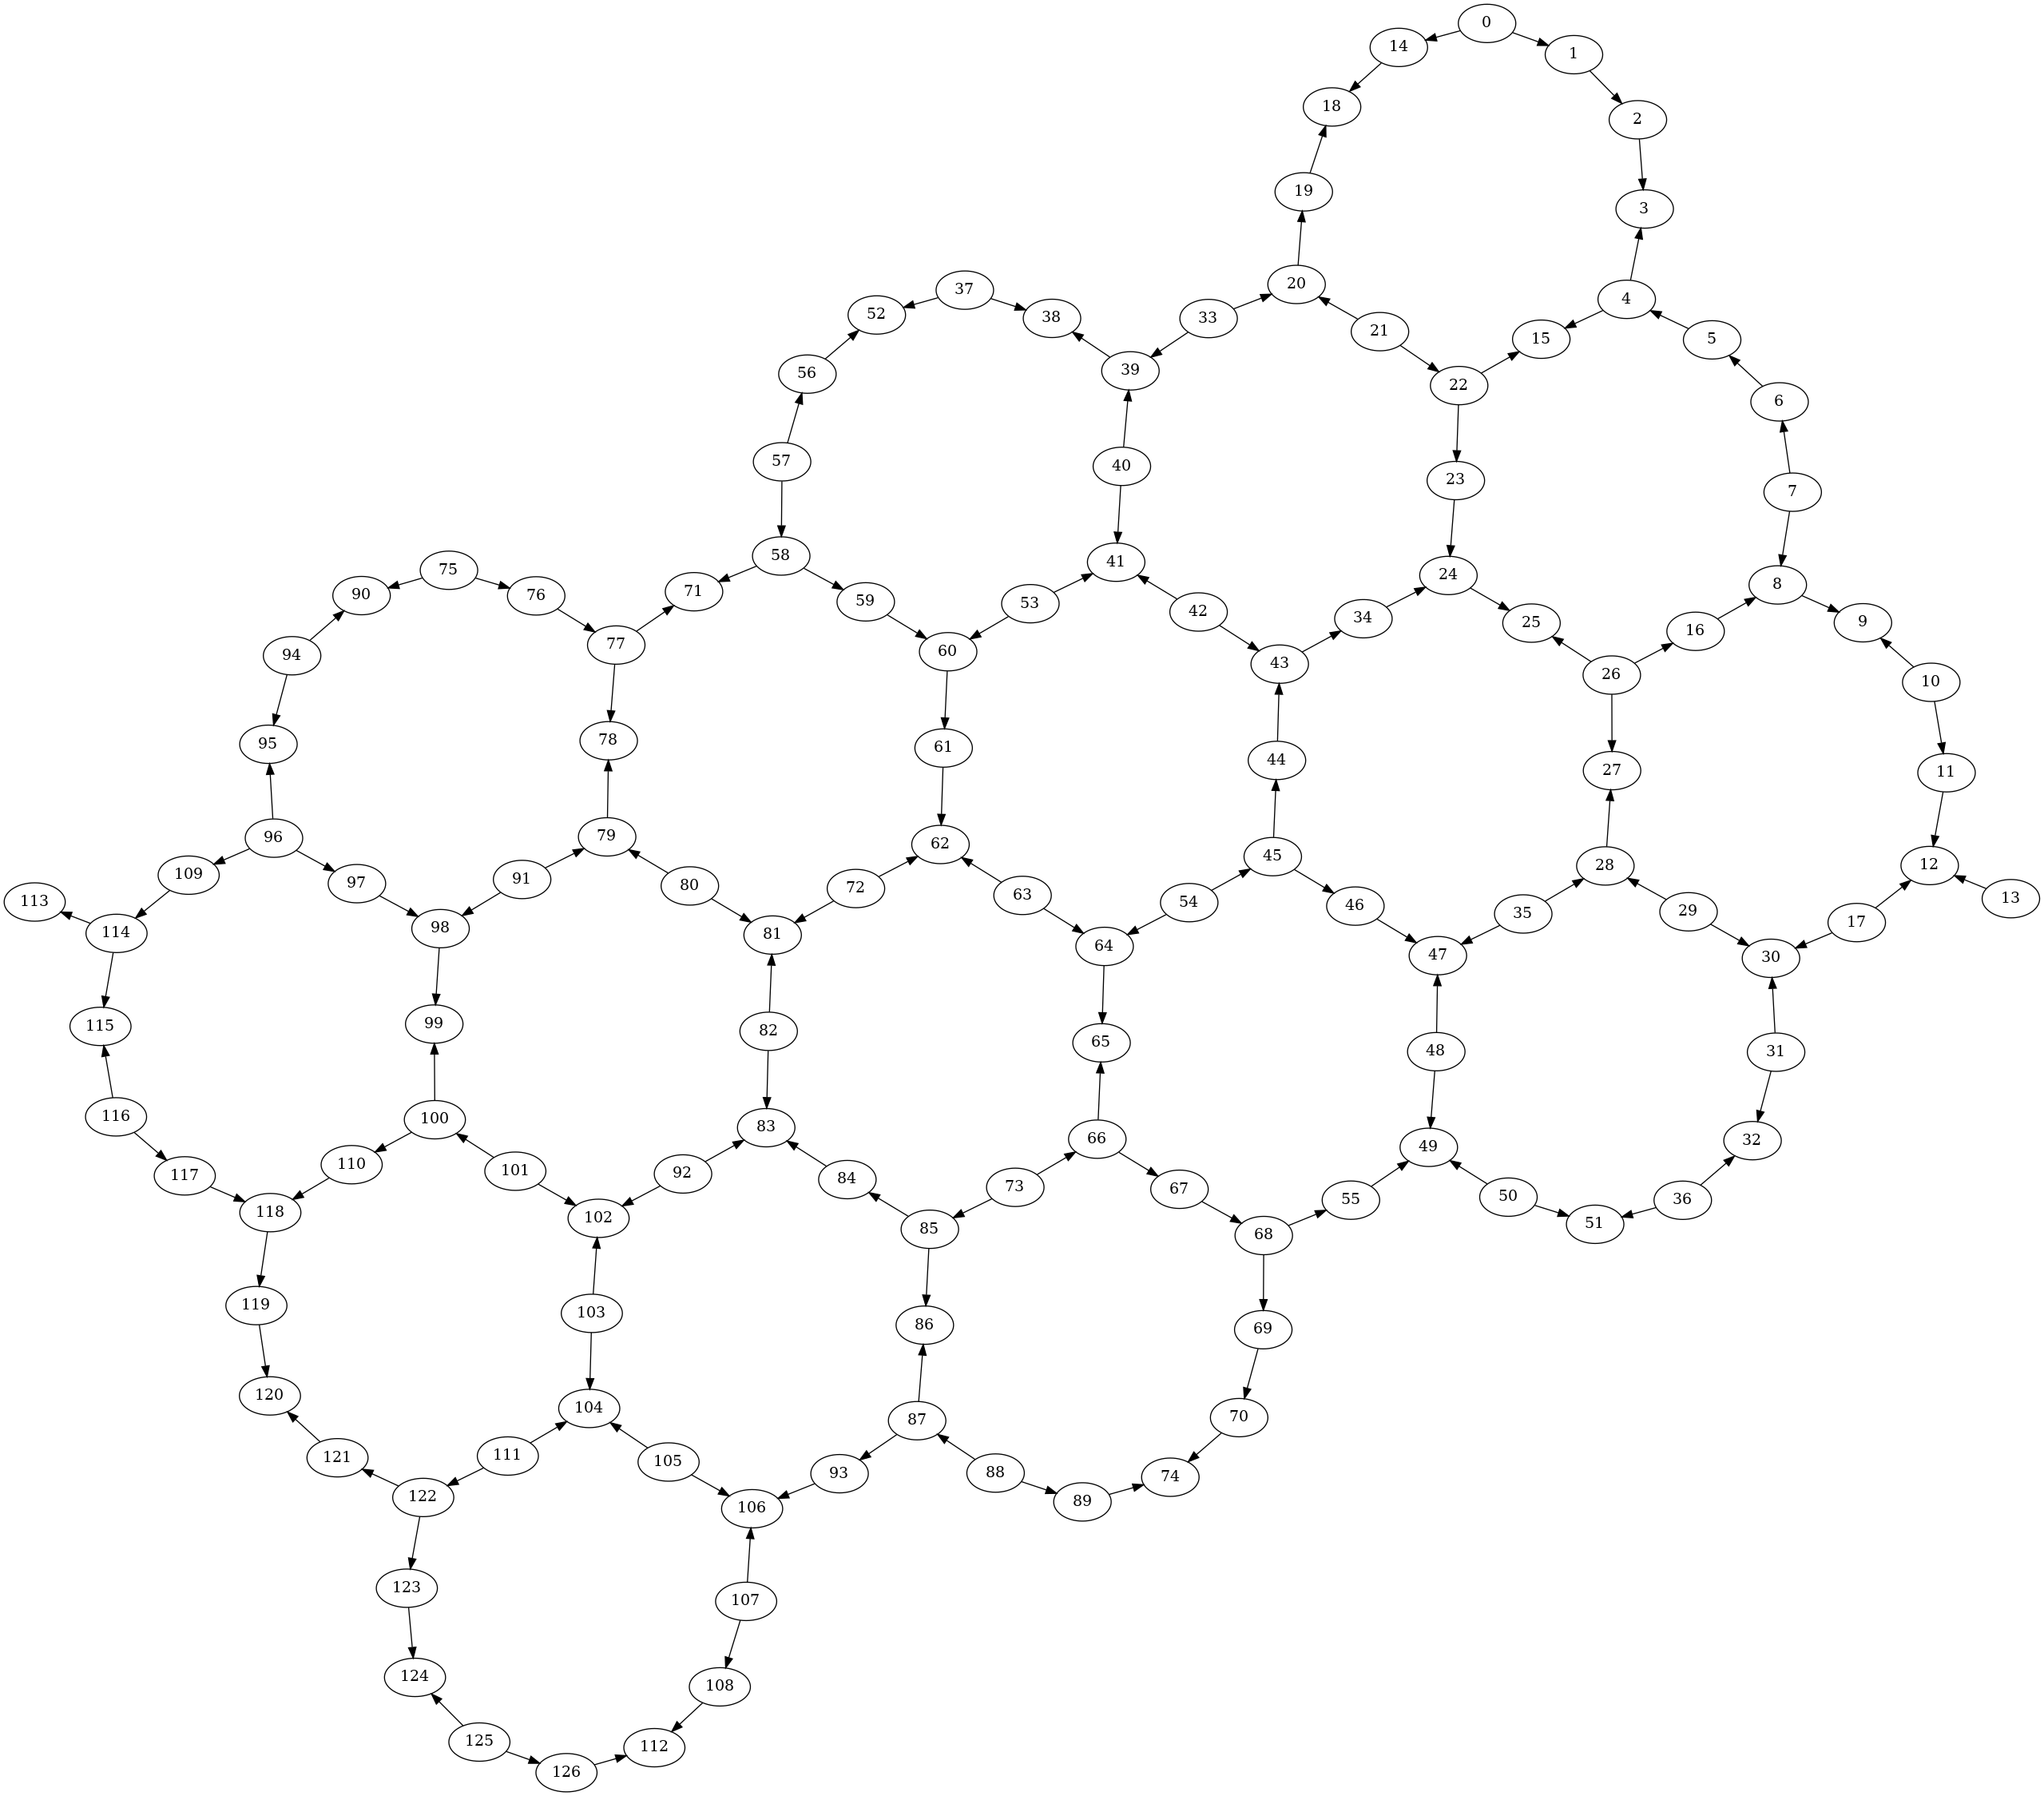

In [37]:
backend = service.backend("ibm_kyiv") 
backend.coupling_map.draw()

To color a coupling map, we use [rustworkx](https://www.rustworkx.org/), which is a Python package for working with graphs and complex networks.  It provides multiple coloring algorithms, which are all heuristic and thus aren't guaranteed to find a minimal coloring.  

Having said this, since heavy-hex graphs are bipartite, we pick up [graph_bipartite_edge_color](https://www.rustworkx.org/apiref/rustworkx.graph_bipartite_edge_color.html), which should find a minimal coloring for these graphs.

In [38]:
def color_coupling_map(backend):
    graph = backend.coupling_map.graph
    undirected_graph = graph.to_undirected(multigraph=False)
    edge_color_map = rx.graph_bipartite_edge_color(undirected_graph)
    if (edge_color_map is None):
        edge_color_map = rx.graph_greedy_edge_color(undirected_graph) 
    # build a map from color to a list of edges
    edge_index_map = undirected_graph.edge_index_map()
    color_edges_map = {color: [] for color in edge_color_map.values()} 
    for edge_index, color in edge_color_map.items():
        color_edges_map[color].append((edge_index_map[edge_index][0], edge_index_map[edge_index][1]))
    return edge_color_map, color_edges_map

Heavy-hexagonal graphs should be painted in three colors.  Let us check this for the above coupling map.

In [39]:
edge_color_map, color_edges_map = color_coupling_map(backend)
print(f"{backend.name}, {backend.num_qubits}-qubit device, {len(color_edges_map.keys())} colors assigned.")

ibm_kyiv, 127-qubit device, 3 colors assigned.


Yes, it is!   

For fun, let us paint the coupling map to the coloring obtained, using the feature of rustworks visualization.

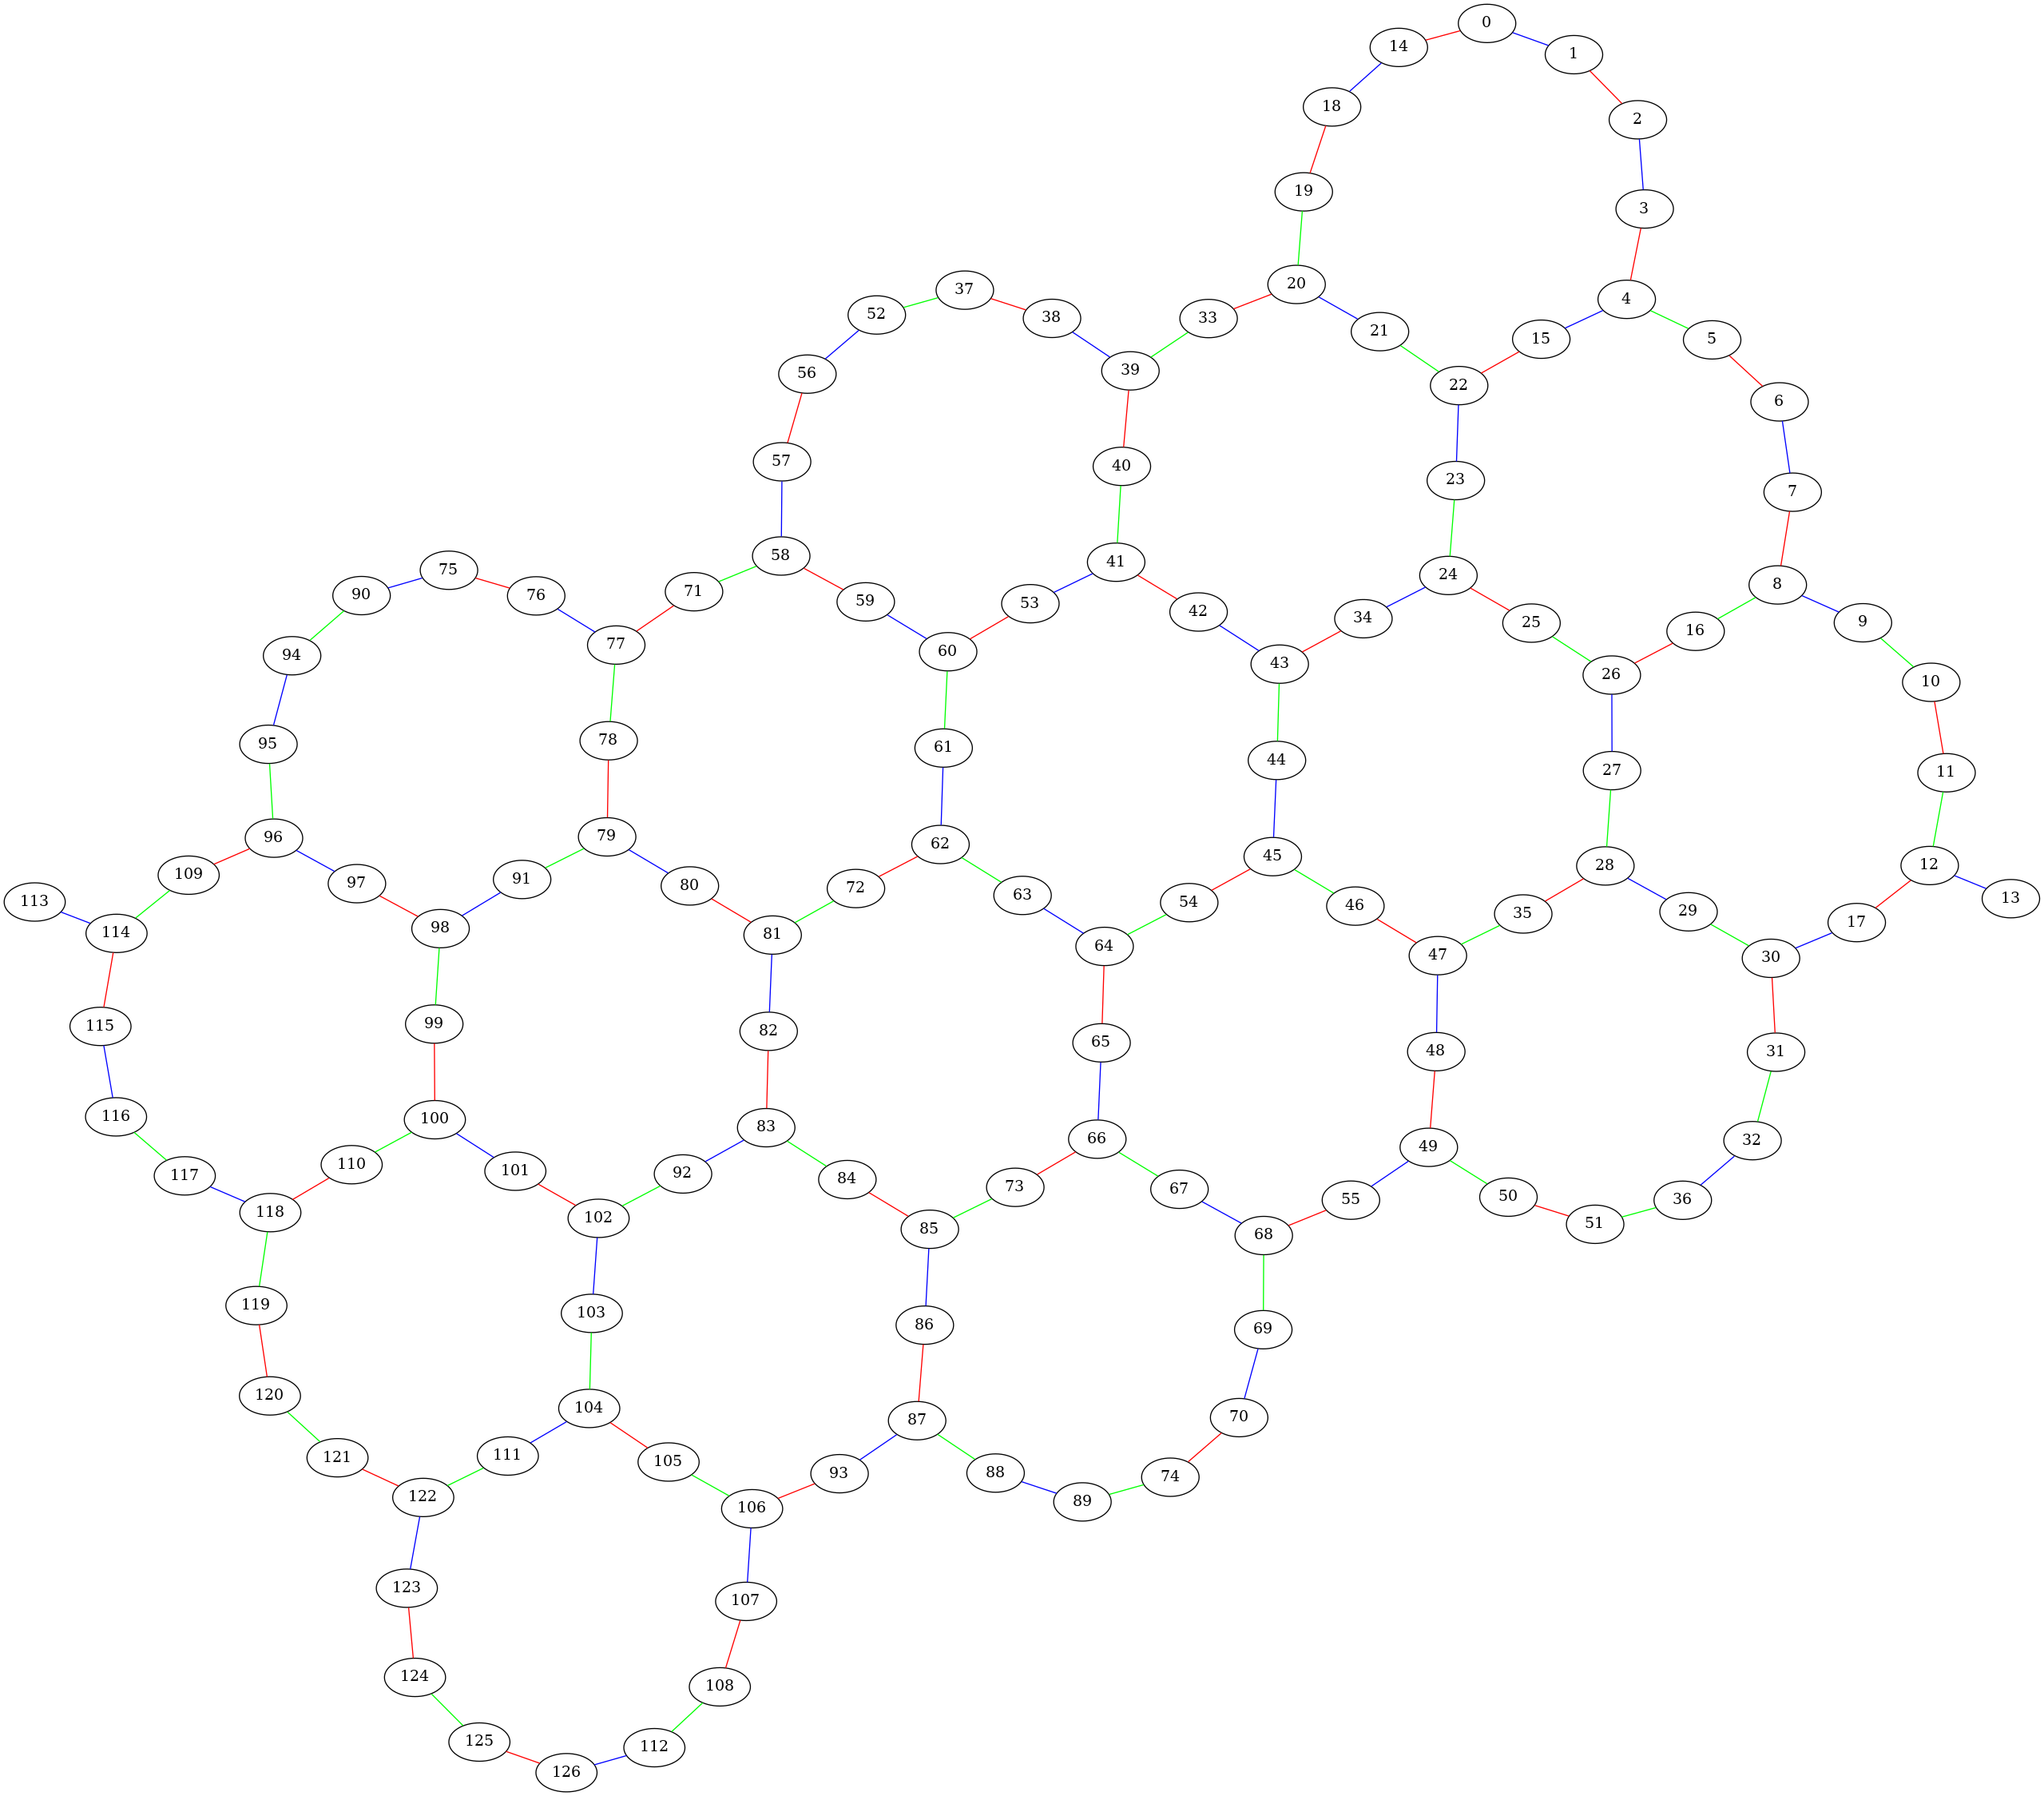

In [40]:
color_str_map = {0: "green", 1: "red", 2: "blue"}

undirected_graph = backend.coupling_map.graph.to_undirected(multigraph=False)
for i in undirected_graph.edge_indices():
    undirected_graph.get_edge_data_by_index(i)["color"] = color_str_map[edge_color_map[i]]

rx.visualization.graphviz_draw(undirected_graph, method="neato", edge_attr_fn=lambda edge: {"color": edge["color"]})

## Solve the Trotterized time evolution of a 2D Ising model.

Let us define a routine to construct a circuit of the utility paper for the time evolution of a 2D Ising model.  The routine takes three parameters, a backend, an integer indicating the number of Trotter steps, and a Boolean controlling the barrier insertion.   

In [41]:
def get_utility_circuit(backend, num_steps: int, barrier: bool = False):
    num_qubits = backend.num_qubits
    _, color_edges_map = color_coupling_map(backend)
    θ_h = Parameter("$\\theta_h$")
    qc = QuantumCircuit(num_qubits)
    
    for i in range(num_steps):
        qc.rx(θ_h, range(num_qubits))


        for _, edge_list in color_edges_map.items():
            for edge in edge_list:
                qc.append(rzz, edge)


        if barrier:
            qc.barrier()
    return qc

Please note that we have already manually performed qubit mapping and routing for the circuit constructed.  Thus, when we transpile the circuit later, we do not (__should not__) ask the transpiler to do qubit mapping and routing. As you will soon see, we invoke it with the optimization level as 1 and the layout method as "trivial".

Next we define a simple routine to get the information about the circuit constructed for a quick check. 

In [42]:
def get_circuit_info(qc: QuantumCircuit, reps: int = 0):
    qc0 = qc.decompose(reps=reps)
    return f"{qc0.num_qubits} qubits × {qc0.depth(lambda x: x.operation.num_qubits == 2)} layers ({qc0.depth()}-depth)" + \
    ",  " + f"""Gate breakdown: {", ".join([f"{k.upper()} {v}" for k, v in qc0.count_ops().items()])}"""

Let us exercise these routines.  You should see a circuit of 27 qubit $\times$ 15 layers (5 Trotter steps). Since the fake device has 28 edges, there should be 28*5 entangling gages.

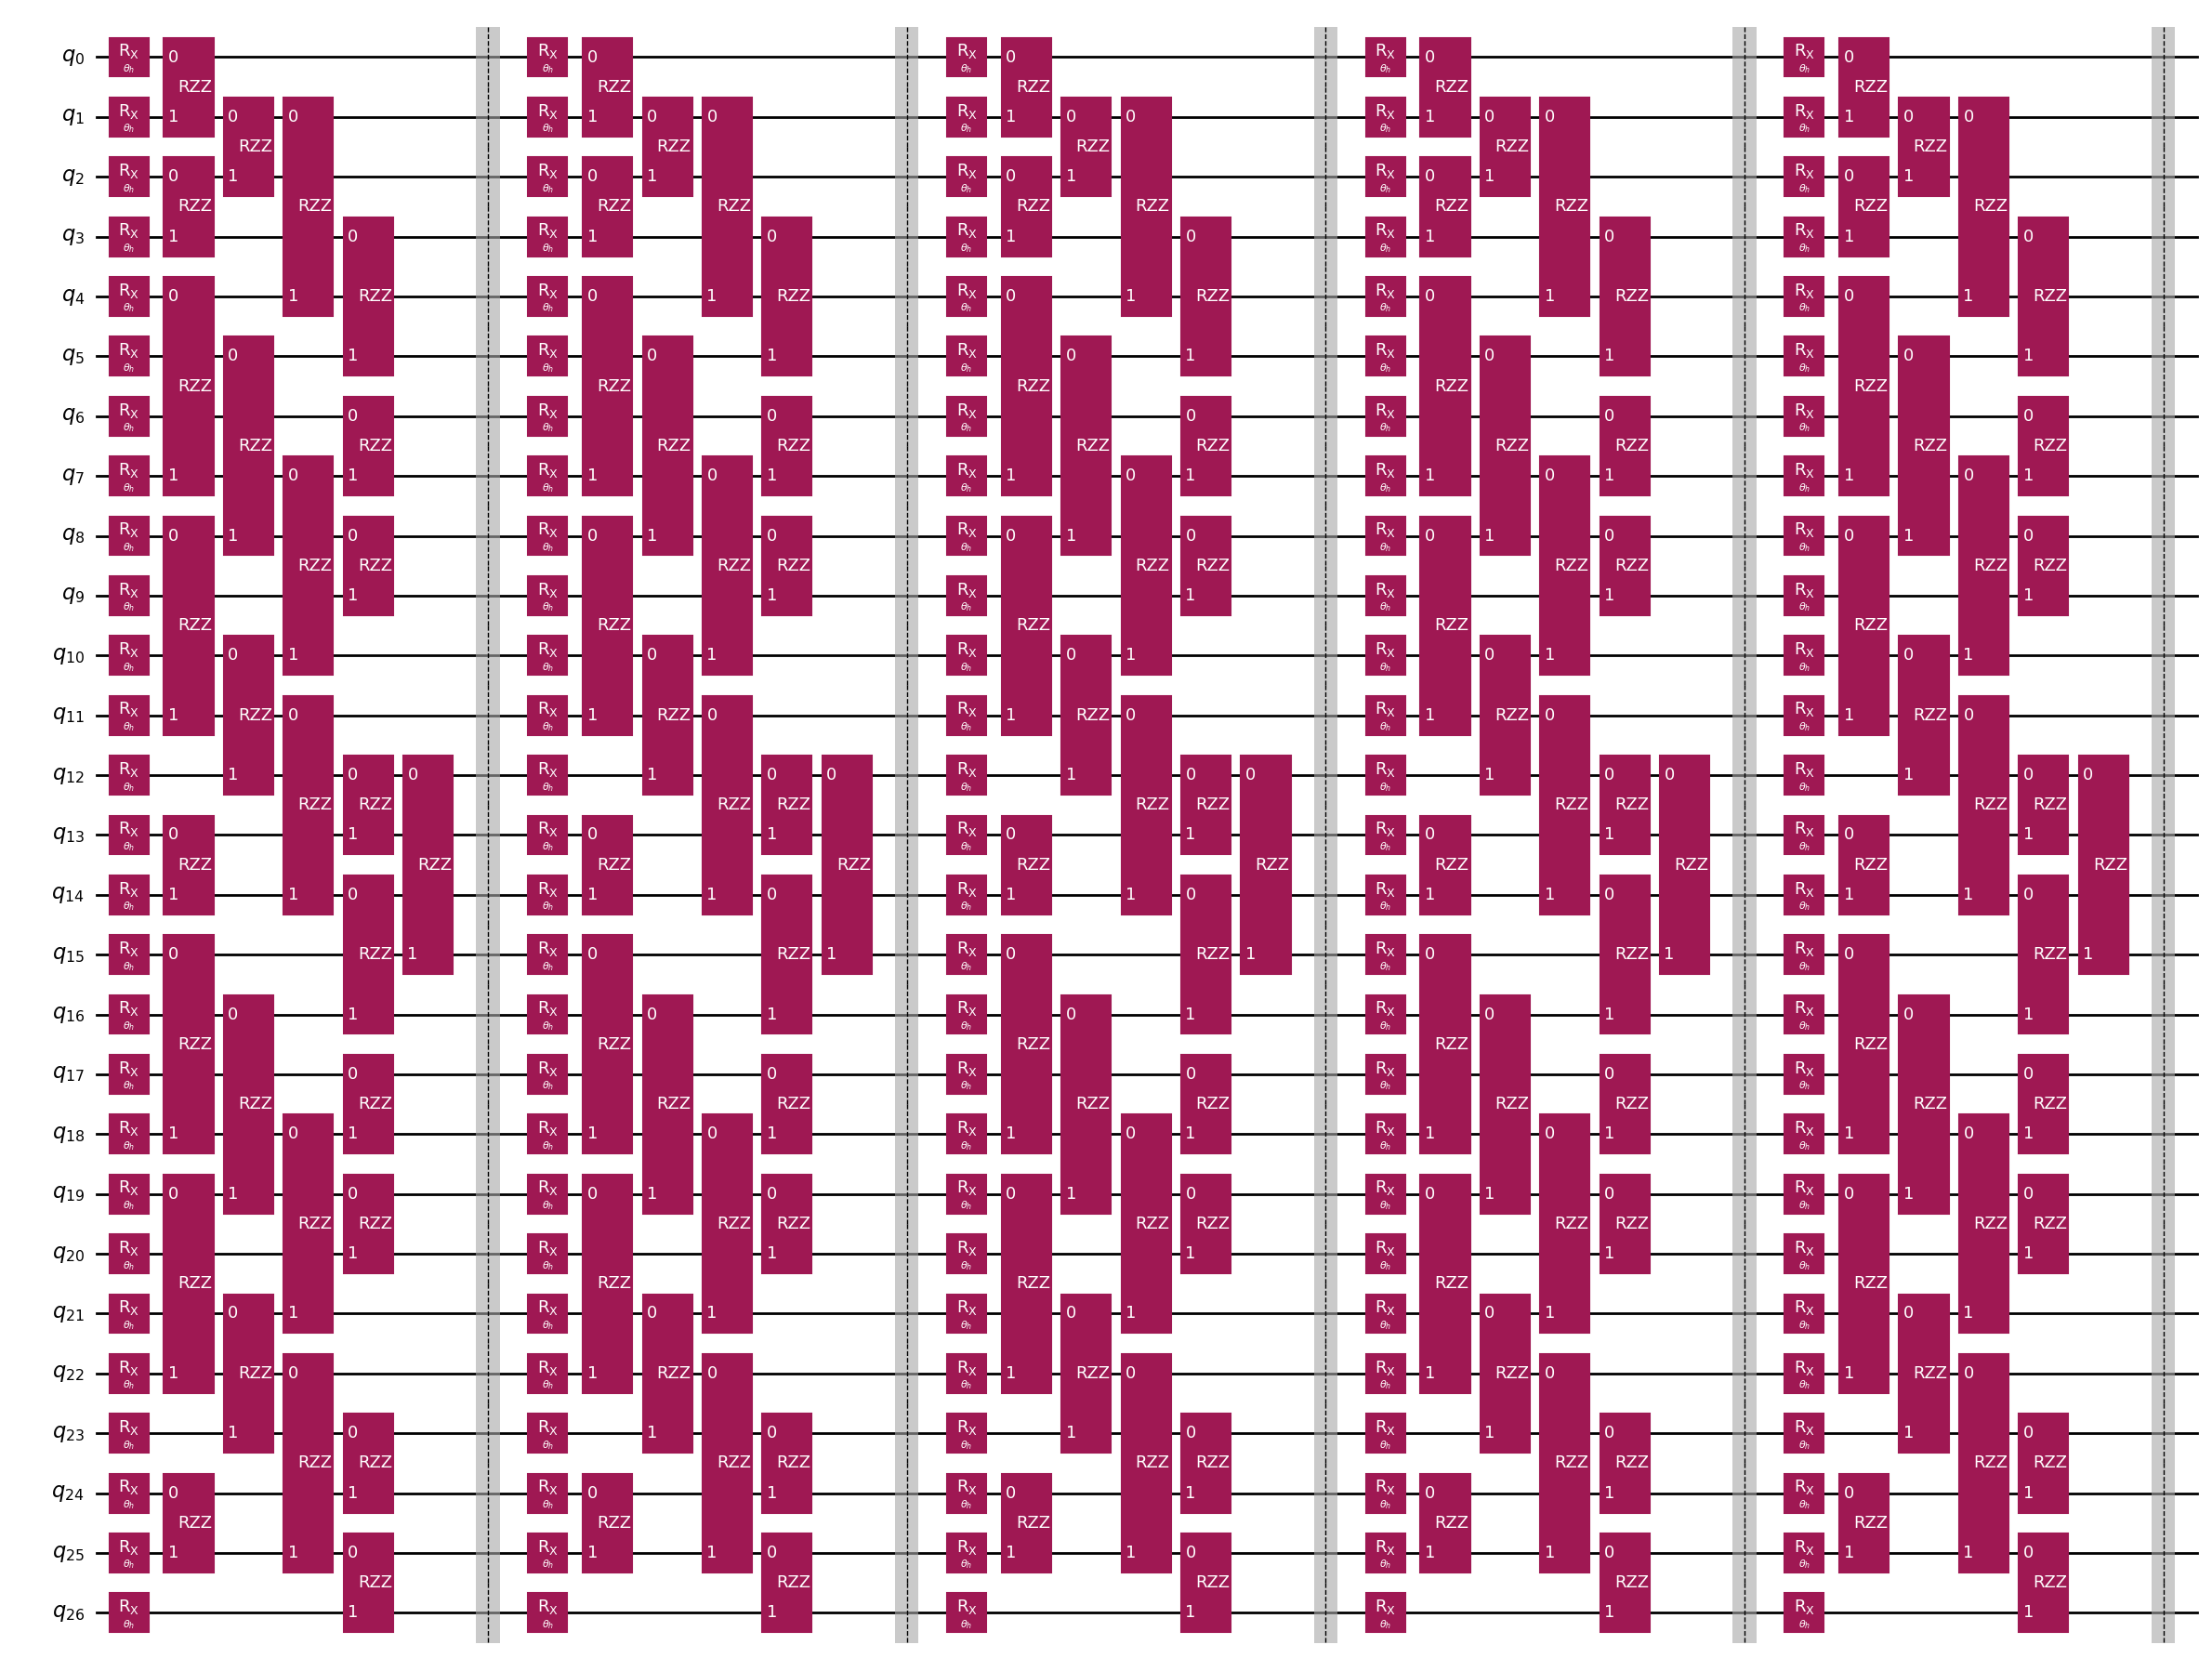

27 qubits × 15 layers (20-depth),  Gate breakdown: CIRCUIT-2238 140, RX 135, BARRIER 5
27 qubits × 15 layers (60-depth),  Gate breakdown: SDG 280, UNITARY 280, CX 140, R 135, BARRIER 5


In [43]:
backend = fake_provider.FakeTorontoV2()
num_steps = 5
qc = get_utility_circuit(backend, num_steps, True)

display(qc.draw(output="mpl", fold=-1))
print(get_circuit_info(qc, reps=0))
print(get_circuit_info(qc, reps=1))

## Solve the 27-qubit version of the problem.

We now demonstrate a smaller-scale version of the utility experiment. We build a 27-qubit $\times$ 6-layer (2 Trotter steps) circuit with $\langle Z_{13} \rangle$ as an observable, and run it both on AerSimulator and a fake device. 

Of course, we follow our four-step workflow, "Qiskit Pattern", which consists of Map, Optimize, Execute, and Post-Process. More concretely,
- Map classical inputs to a quantum computation.
- Optimize circuits for quantum computation.
- Execute circuits using primitives.
- Post-process and return results in classical format.

In the following, we have the Map step for creating a circuit for a smaller-scale experiment. We then have one set of Optimize and Execute for AerSimulator and another for a fake device.  Finally, we have the Post-Process step to plot the results. 

#### Step 1: Map

In [44]:
backend = fake_provider.FakeTorontoV2()    # a 27 qubit fake device.
num_steps = 2
qc = get_utility_circuit(backend, num_steps)
obs = SparsePauliOp.from_sparse_list([("Z", [13], 1)], num_qubits=backend.num_qubits) # Falcon
angles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, np.pi/2]   # We try 11 angles for theta_h.

#### Steps 2 and 3: Optimize and Execute (Simulator)

In [45]:
backend_sim = AerSimulator()
transpiled_qc_sim = transpile(qc, backend_sim, optimization_level=1, layout_method="trivial")
transpiled_obs_sim = obs.apply_layout(layout=transpiled_qc_sim.layout)

print(get_circuit_info(qc, reps=1))
print(get_circuit_info(transpiled_qc_sim, reps=1))

27 qubits × 6 layers (23-depth),  Gate breakdown: SDG 112, UNITARY 112, CX 56, R 54
27 qubits × 6 layers (16-depth),  Gate breakdown: U3 80, CX 56, R 54, U1 32, U 28


One user ran the next cell using a MacBook Pro with 2.3 GHz quad-core Intel Core i7 Processor eqipped with 32GB 3LPDDR4X RAM which is running macOS 14.5.  It took 161ms in Wall time. Each laptop will be slightly different.

In [46]:
%%time 
params = [[p] for p in angles]
estimator = Estimator(mode=backend_sim)
pub = (transpiled_qc_sim, transpiled_obs_sim, params)
result_sim = estimator.run([pub]).result()

CPU times: user 672 ms, sys: 663 ms, total: 1.34 s
Wall time: 172 ms


####  Steps 2 and 3: Optimize and Execute (Fake device)

In [47]:
backend_fake = fake_provider.FakeTorontoV2() 
transpiled_qc_fake = transpile(qc, backend_fake, optimization_level=1, layout_method="trivial")
transpiled_obs_fake = obs.apply_layout(layout=transpiled_qc_fake.layout)

print(get_circuit_info(qc, reps=1))
print(get_circuit_info(transpiled_qc_fake, reps=1))

27 qubits × 6 layers (23-depth),  Gate breakdown: SDG 112, UNITARY 112, CX 56, R 54
27 qubits × 6 layers (49-depth),  Gate breakdown: SDG 324, U1 274, H 162, CX 56, U3 14


When the same user ran the next cell with the same environment as above, it took 2min 19s in Wall Time.  Executing a circuit on a fake device invokes noisy simulation which takes much longer time than exact simulation.   We recommend you not execute a larger circuit (such as a 27-qubit $\times$ 9 layers with 3 Trotter steps) on a fake device.

In [48]:
%%time 
params = [[p] for p in angles]
estimator = Estimator(mode=backend_fake)
pub = (transpiled_qc_fake, transpiled_obs_fake, params)
result_fake = estimator.run([pub]).result()

CPU times: user 12min, sys: 9.82 s, total: 12min 10s
Wall time: 46.7 s


#### Step 4: Post-process

We plot the results from exact and noisy simulations. You see the severe effects of noise on FakeToronto.

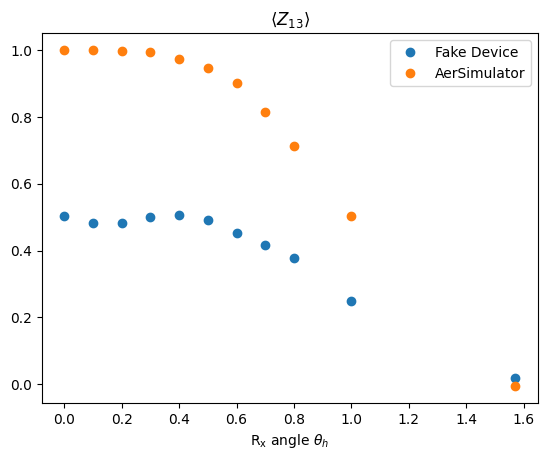

In [49]:
plt.plot(angles, result_fake[0].data.evs, "o", label="Fake Device")
plt.plot(angles, result_sim[0].data.evs, "o", label="AerSimulator")
plt.xlabel("$\\mathrm{R_x}$ angle $\\theta_h$")
plt.title("$\\langle Z_{13} \\rangle$")
plt.legend()
plt.show()

## Solve the 127-qubit version of the problem.

It is your goal to run the utility-scale experiment as mentioned at the beginning. You will create and execute a 127-qubit and 60-layer (20 Trotter steps) circuit with  $\langle Z_{62} \rangle$ as an observable. We recommend you try to do this yourself, using the code for the 27-qubit version when appropriate. But the solution is provided here.

__Solution:__

#### Step 1: Map

In [50]:
backend_map = service.backend("ibm_kyiv") 

num_steps = 20
qc = get_utility_circuit(backend_map, num_steps)
obs = SparsePauliOp.from_sparse_list([("Z", [62], 1)], num_qubits=backend_map.num_qubits) # Eagle
angles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, np.pi/2]

#### Step 2: Optimize and Execute

We note that the coupling map of the Eagle processor has 144 edges. 

In [ ]:
backend = service.backend("ibm_kyiv") 

transpiled_qc = transpile(qc, backend, optimization_level=1, layout_method="trivial")
transpiled_obs = obs.apply_layout(layout=transpiled_qc.layout)

print(get_circuit_info(qc, reps=1))
print(get_circuit_info(transpiled_qc))

127 qubits × 60 layers (260-depth),  Gate breakdown: SDG 5760, UNITARY 5760, CX 2880, R 2540
127 qubits × 60 layers (302-depth),  Gate breakdown: RZ 12399, SX 3924, X 3243, ECR 2880


In [25]:
params = [[p] for p in angles]
estimator = Estimator(mode=backend)
pub = (transpiled_qc, transpiled_obs, params)
job = estimator.run([pub])

print(f"job id={job.job_id()}")

job id=ctxq4t3ckyk0008a81pg


#### Post-process

We provide the values for the "mitigated" points in Figure 4b of the utility paper.   Please plot these together with your results. 

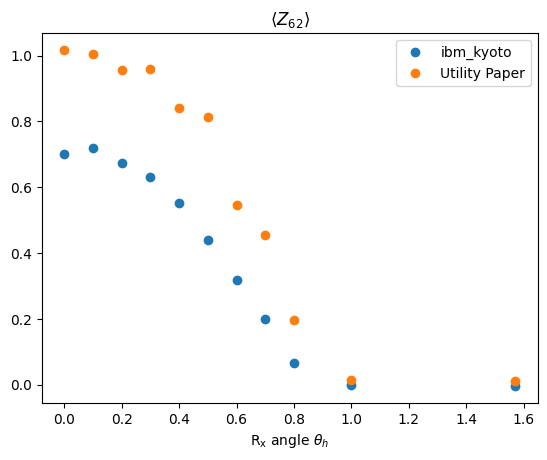

In [26]:
result_paper = [1.0171, 1.0044, 0.9563, 0.9602, 0.8394, 0.8120, 0.5466, 0.4556, 0.1953, 0.0141, 0.0117]

# REPLACE WITH YOUR OWN JOB ID
job = service.job("ctxq4t3ckyk0008a81pg")

plt.plot(angles, job.result()[0].data.evs, "o", label=f"{job.backend().name}")
plt.plot(angles, result_paper, "o", label="Utility Paper")
plt.xlabel("$\\mathrm{R_x}$ angle $\\theta_h$")
plt.title("$\\langle Z_{62} \\rangle$")
plt.legend()
plt.show()

Are your results similar to the "unmitigated" in Figure 4b? &nbsp; They could be very different, depending on the device and its condition at the time of experiment.  Do not worry about the results themselves. What we will check is whether you have done the coding correctly.  If you have done so, congratulations, you have reached the starting line of the utility era.

As in the Utility paper, scientists across the globe have put forth tremendous ingenuity to extracting meaningful results even in the presence of noise. The end goal of this collective effort is quantum advantage: a state in which quantum computers can solve some problems of use in industry faster, with higher fidelity, or more cheaply than classical computers. This is not likely to be a single event, but rather an era in which classical reproduction of quantum results takes progressively longer, until at some point that quantum lead time becomes critically important. One thing is clear about quantum advantage: we get there only through the utility-scale experiments.  If this course results in your joining the quest, which is full of challenge and fun, we would be more than happy. 

## Reference

- Kim, Y., Eddins, A., Anand, S. et al. Evidence for the utility of quantum computing before fault tolerance. Nature 618, 500–505 (2023). https://doi.org/10.1038/s41586-023-06096-3